### Napari tests

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os , sys
sys.path.append('..')
from pathlib import Path
cur_path = Path(os.getcwd()).parent

from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme(style='white')
%config InlineBackend.figure_format = 'retina'

In [3]:
import napari

In [4]:
viewer = napari.Viewer()

2025-01-24 10:25:12.986 python[27811:8476003] +[IMKClient subclass]: chose IMKClient_Modern
2025-01-24 10:25:12.986 python[27811:8476003] +[IMKInputSession subclass]: chose IMKInputSession_Modern


#### Initiate the SAM2 model like you do in Napari

In [5]:
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import torch
from octron.sam2_octron.helpers.build_sam_octron import build_sam2_video_predictor_octron

In [6]:
sam2_folder = Path('sam2_octron')
checkpoint = 'sam2.1_hiera_large.pt' # under folder /checkpoints
model_cfg = 'sam2.1/sam2.1_hiera_l.yaml' # under folder /configs
# ------------------------------------------------------------------------------------
sam2_checkpoint = cur_path / sam2_folder / Path(f'checkpoints/{checkpoint}')
model_cfg = Path(f'configs/{model_cfg}')


predictor, device  = build_sam2_video_predictor_octron(config_file=model_cfg.as_posix(), 
                                                       ckpt_path=sam2_checkpoint.as_posix(), 
                                     )


Support for MPS devices is preliminary. SAM 2 is trained with CUDA and might give numerically different outputs and sometimes degraded performance on MPS. See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion.
Uing device: mps


Loaded SAM2VideoPredictor OCTRON
Model image size: 1024


### From napari, after loading video file, extract info 

In [7]:
# ... first load video into napari 

In [10]:
viewer.dims.set_point(0,20)
current_indices = viewer.dims.current_step
print(current_indices)

(20, 971, 971)


In [11]:
video_data = viewer.layers[0].data   # the whole video

print(f'video shape: {video_data.shape}')   
num_frames, height, width, _ = video_data.shape


video shape: (1603, 1944, 1944, 3)


In [12]:
inference_state = predictor.init_state(napari_data=video_data)

/Users/horst/miniconda3/envs/sam2/lib/python3.10/site-packages/torch/nn/functional.py:4594: UserWarning: The operator 'aten::upsample_bicubic2d.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  return torch._C._nn.upsample_bicubic2d(


Initialized SAM2 model


In [13]:
# viewer.dims.set_point(0,10)
# current_indices = viewer.dims.current_step
# print(current_indices)
# image_data1 = viewer.layers[0].data[current_indices[0],:,:,:]
# image_data1.shape
# plt.imshow(image_data1)
# plt.show() 
# # Set to different index 
# viewer.dims.set_point(0,11)
# current_indices = viewer.dims.current_step
# print(current_indices)
# current_indices = viewer.dims.current_step
# image_data2 = viewer.layers[0].data[current_indices[0],:,:,:]
# image_data2.shape
# plt.imshow(image_data2)


In [14]:
predictor.reset_state(inference_state)

In [15]:
from sam2_octron.helpers.visualization import show_points, show_mask

In [16]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)
# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array([[1438,529]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
# Predict 
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 2  # give a unique id to each object we interact with (it can be any integers)
# Let's add a positive click at (x, y) = (210, 350) to get started
points2 = np.array([[425,501]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
# Predict 
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points2,
    labels=labels,
)
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 3  # give a unique id to each object we interact with (it can be any integers)
# Let's add a positive click at (x, y) = (210, 350) to get started
points3 = np.array([[1340,1571],[1373,1326]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1,0], np.int32)
# Predict 
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points3,
    labels=labels,  
)


In [24]:
obj

2

In [25]:
out_mask_logits[0] > 0

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='mps:0')

In [35]:
mask = (out_mask_logits[0] > 0).cpu().numpy().astype(np.uint8)
mask.shape

(1, 1944, 1944)

In [34]:
# Add the mask image as a new labels layer
labels_layer = viewer.add_labels(
    mask,  # The mask image data
    name='Mask2 Layer',  # Name of the layer
    opacity=0.6,  # Optional: opacity of the labels
    blending='additive'  # Optional: blending mode
)


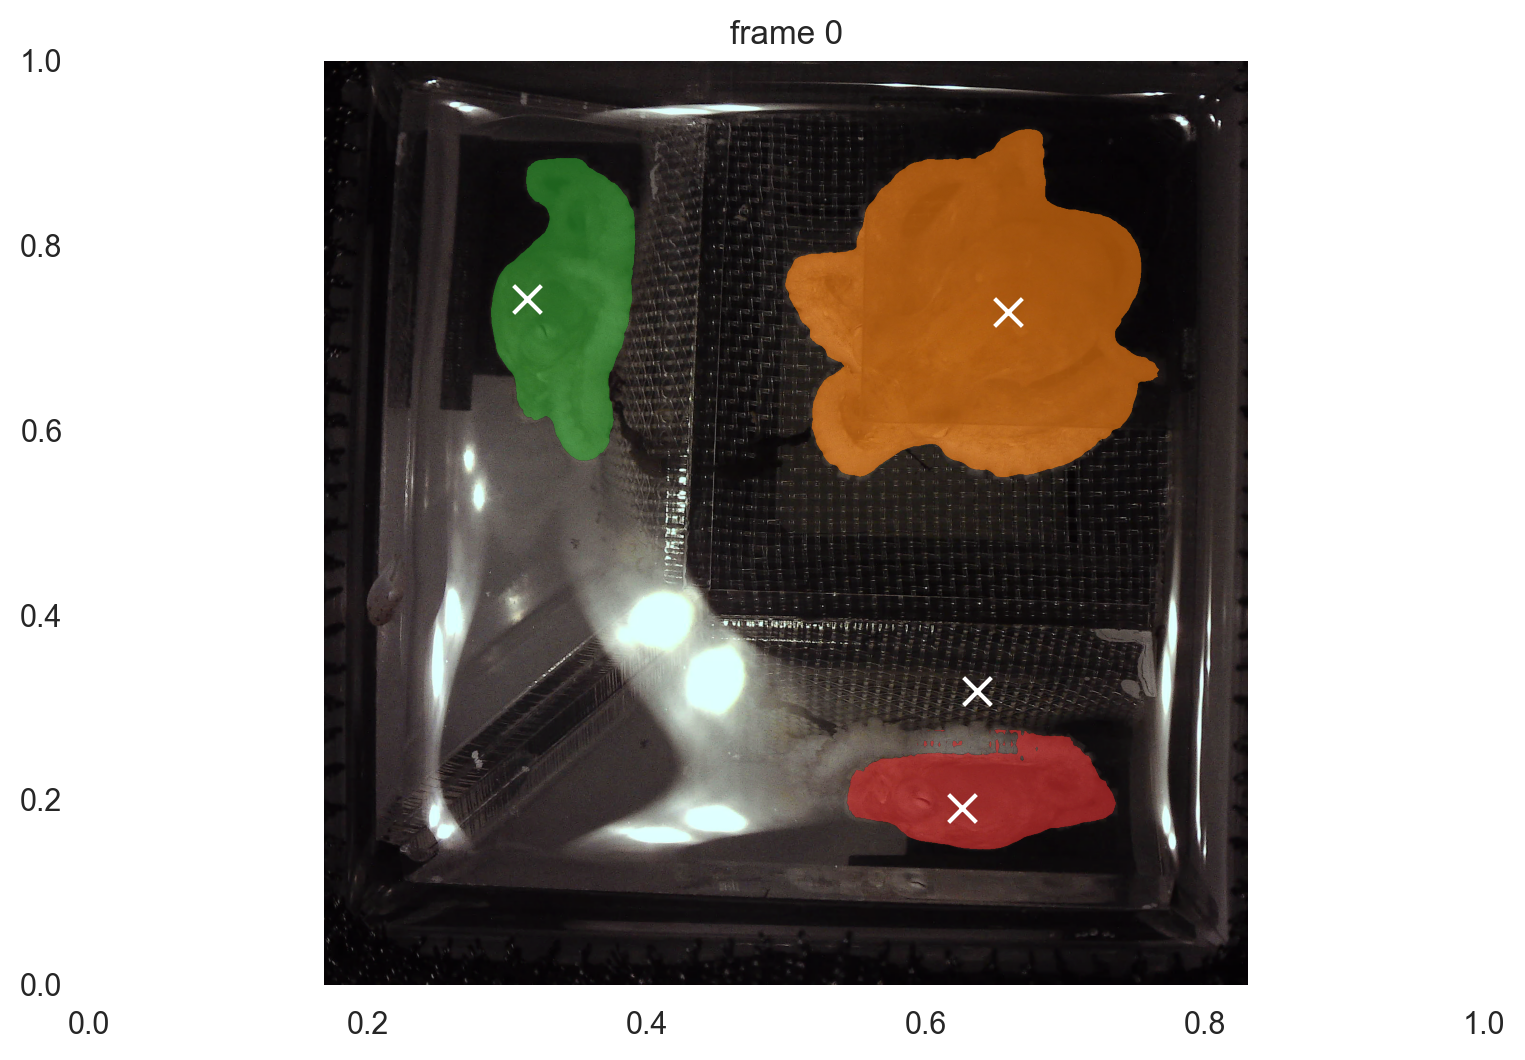

In [17]:
# show the results on the current (interacted) frame
figure = plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
ax = figure.add_subplot(111)
ax.set_yticks([]); ax.set_xticks([])    

ax.imshow(video_data[0])

for obj in range(out_mask_logits.shape[0]):
    show_mask((out_mask_logits[obj] > 0).cpu().numpy(), ax, obj_id=out_obj_ids[obj])

for p in points: # show the clicked points
    ax.scatter(p[0], p[1], marker='x',s=100, color='white')
for p in points2: # show the clicked points
    ax.scatter(p[0], p[1], marker='x',s=100, color='white')
for p in points3: # show the clicked points
    ax.scatter(p[0], p[1], marker='x',s=100, color='white')
sns.despine(left=True,bottom=True)

In [18]:
viewer.add_layer

Viewer(camera=Camera(center=(0.0, np.float64(971.5), np.float64(971.5)), zoom=np.float64(0.3316936728395061), angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(np.float64(20.0), np.float64(1771.9373001815936), np.float64(2109.598241764245)), scaled=True, style=<CursorStyle.STANDARD: 'standard'>, size=1.0), dims=Dims(ndim=3, ndisplay=2, order=(0, 1, 2), axis_labels=('0', '1', '2'), rollable=(True, True, True), range=(RangeTuple(start=np.float64(0.0), stop=np.float64(1602.0), step=np.float64(1.0)), RangeTuple(start=np.float64(0.0), stop=np.float64(1943.0), step=np.float64(1.0)), RangeTuple(start=np.float64(0.0), stop=np.float64(1943.0), step=np.float64(1.0))), margin_left=(0.0, 0.0, 0.0), margin_right=(0.0, 0.0, 0.0), point=(np.float64(20.0), np.float64(971.0), np.float64(971.0)), last_used=0), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'bottom-left_03092023_PM-37' at 0x17c5509a0>], help='use <2> for tr